In [1]:
import sncosmo
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from pandas import read_csv
from scipy.integrate import cumulative_trapezoid as cumtrapz
import astropy.constants as co
import astropy.units as u
import astropy.cosmology.units as cu
from scipy import interpolate
from astropy.cosmology import WMAP9 as cosmo
import extinction
import math
import scipy.stats as stats
from scipy.interpolate import CubicSpline
import time


DAY_CGS = u.day
M_SUN_CGS = co.M_sun
C_CGS = co.c
beta = 13.7
KM_CGS = u.km

STEF_CONST = 4. * np.pi * co.sigma_sb
ANG_CGS = u.Angstrom
MPC_CGS = u.Mpc

DIFF_CONST = 2.0 * M_SUN_CGS / (beta * C_CGS * KM_CGS)
TRAP_CONST = 3.0 * M_SUN_CGS / (4. * np.pi * KM_CGS ** 2)
FLUX_CONST = 4.0 * np.pi * (
        2.0 * co.h * co.c ** 2 * np.pi) * u.Angstrom
X_CONST = (co.h * co.c / co.k_B)

In [355]:
class ArnettSource(sncosmo.Source):

    _param_names = ['mej', 'fni', 'vej']
    param_names = ['mej', 'fni', 'vej']

    param_names_latex = ['M_{ej}', 'f_{Ni}', 'v_{ej}']   # used in plotting display

    def __init__(self, phase, wave, redshift, texp, params=None, name=None, version=None):
        
        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        self._z = redshift
        self._texp = texp
        self._tfloor = 3000 * u.K
        if params is not None:
            self._parameters = params
        else:
            self._parameters = [0, 0, 0]

    def _blackbody_flux(self, temperature, radius, wavelength):
        # Convert wavelength from Angstrom to cm

        all_fluxes = np.zeros((len(temperature), len(wavelength))) * (u.erg / (u.s * u.AA)).decompose()
        for i in range(len(temperature)):
            temp = temperature[i]
            rad = radius[i]

            # Planck function numerator: 2hc^2 / λ^5
            numerator = (2 * co.h * co.c**2 / wavelength**5).decompose()

            # Exponent of the Planck function
            exponent = (co.h * co.c / (wavelength * co.k_B * temp)).decompose()

            # Compute denominator, stripping unit to pass into np.exp safely
            denominator = np.exp(exponent.value) - 1

            # Spectral radiance: Planck's law in SI units (W / (m^2 m))
            flux_density = numerator / denominator  # Units: W / (m²·m)

            # Convert to flux at the source: multiply by 4πR²
            flux_final = flux_density * (4 * np.pi * rad**2)

            # Assign to all_fluxes
            all_fluxes[i, :] = flux_final
        return all_fluxes 


    def _gen_arnett_model(self, t, wvs, redshift, texp, theta):
        mej, fni, vej = theta
        mej = (mej * u.Msun).to(u.g)
        vej = vej * u.km/u.s
        t = t * u.day
        wvs = wvs * u.AA
        tfloor = self._tfloor
        # Convert to grams
        # mej = mej * M_SUN_CGS
        mni = mej * fni
        # Convert velocity to cm/s
        # vej = vej * 1e8
        vej = vej.to(u.cm / u.s)

        tni = 8.8 * u.day  # days
        tco = 111.3  * u.day # days
        epco = 6.8e9 * u.erg / u.g / u.s # erg/g/s
        epni = 3.9e10 * u.erg / u.g / u.s # erg/g/s
        opac = 0.1 *u.cm * u.cm/u.g        
        texp = texp * u.day
        # t -= texp
        # t = t - texp
        # Diffusion timescale in days
        td = np.sqrt(2 * opac * mej / (13.7 * co.c * vej)).to(u.day)   # convert seconds to days
        td -= texp
        # t_to_integrate = np.hstack((np.array(0.), t))
        # t_to_integrate = np.linspace(0, np.max(t - texp), 1000)
        t_to_integrate = np.linspace(0, np.max(t - texp), 1000)

        
        
        # td = np.sqrt(2 * opac * mej / (13.7 * C_CGS * vej)) / 86400  # convert seconds to days
        integrand1 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tni)
        integrand2 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tco)

        # Luminosity calculation
        dense_luminosities = 2 * mni / (td) * np.exp(-t_to_integrate**2 / td**2) * \
              (((epni - epco) * cumtrapz(integrand1, t_to_integrate, initial=0) + 
               epco * cumtrapz(integrand2, t_to_integrate, initial=0)))*u.day # these should be erg/s
        
        spline = CubicSpline(t_to_integrate, dense_luminosities, extrapolate = False)
        luminosities = spline(t - texp) * u.erg / u.s # interpolate back from dense time array to original time points
        # print(luminosities)
        # print(['{:f}'.format(i) for i in t])
        # plt.plot(t, luminosities, 'o')
        # plt.show()
        #Do BB calculation
        radius = (vej * ((t - texp) * ((t-texp)>=0))).to(u.cm)
        # print(radius)

        temperature = ((luminosities / (STEF_CONST * radius**2))**0.25).to(u.K)# * (1e52)**0.25
        gind = (temperature < tfloor) | np.isnan(temperature)
        temperature = np.nan_to_num(temperature)
        notgind = np.invert(gind)
        temperature = (0. * temperature) + (temperature * notgind) + (tfloor * gind)
        
        radius = np.sqrt(luminosities / (STEF_CONST * temperature**4))
        radius = radius.to(u.cm)

        fluxes = self._blackbody_flux(temperature, radius, wvs) # this is a luminosity density
        fluxes[t < texp,:] = 1e-10 * 1000 *u.kg *u.m / u.s**3

        
        # divide luminosity density by 4pir^2 to get flux
        z = redshift * cu.redshift
        d_cm = z.to(u.cm, cu.redshift_distance(cosmo, kind="luminosity"))
        flux_density = fluxes / (4 * np.pi * d_cm**2) 
        return flux_density


    def _flux(self, phase, wave):
        return self._gen_arnett_model(phase, wave, self._z, self._texp, self._parameters)

In [356]:
ibc_df = read_csv("merged_ibc_with_redshift.csv")
ia_df = read_csv("merged_modelpar_Ia_with_redshift.csv")

In [357]:
ibc_df

,object_id,true_z,submodel,sim_av,IBC_INDEX,Mejecta,Kinetic_energy,F_nickel
0,268,0.621,2,0.1007,569,4.0460,1.3293,0.0744
1,1304,0.309,2,0.8308,577,6.1297,2.4682,0.0565
2,1660,0.817,2,0.0018,670,9.8119,4.1647,0.0849
3,2407,0.586,2,0.0108,500,1.1125,7.1842,0.0801
4,3073,0.441,2,0.2936,395,2.0126,3.4670,0.0448
...,...,...,...,...,...,...,...,...
107415,130781910,0.182,2,0.2772,655,7.6406,1.5965,0.0980
107416,130782585,0.532,2,0.1348,689,7.5367,4.1214,0.1377
107417,130786504,0.191,2,0.0949,115,3.0187,2.0357,0.0159
107418,130786889,0.242,2,0.1977,552,2.6411,6.0234,0.0612


In [358]:
times = np.linspace(0.1,100,100) # days
wavelengths = np.linspace(2000,12000,10) # Angstroms
# texp = 5

num_points = 10
time_points = np.linspace(0.01,100, num_points) # to observe
num_points = len(time_points)
# bands = ['lsstu', 'lsstg', 'lsstr', 'lssti', 'lsstz', 'lssty']

bands = ['lsstg', 'lsstr', 'lssti', 'lsstz', 'lssty']


# zeropoints from https://smtn-002.lsst.io/
# zeropoints = [26.52, 28.51, 28.36, 28.17, 27.78, 26.82]
zeropoints = [28.51, 28.36, 28.17, 27.78, 26.82]

num_bands = len(bands)

obs = Table({'time': list(time_points) * num_bands,
             'band': np.repeat(bands, num_points),
            'zp': zeropoints*num_points, 'zpsys':['ab']*num_points*num_bands, 
             'gain':np.ones(num_points*num_bands), 'skynoise':10*np.ones(num_points*num_bands)})

In [359]:
def simulate_ibc(true_z, texp, mej, fni, vej):
    # arnett_source = ArnettSource(times, wavelengths, true_z, params=[mej, fni, vej])
    arnett_source = ArnettSource(times, wavelengths, true_z, texp, params=[mej, fni, vej])

    arnett_model = sncosmo.Model(source=arnett_source)
    params = {'mej': mej, 'fni': fni, 'vej': vej}

    lcs = sncosmo.realize_lcs(obs, arnett_model, [params])
    return lcs

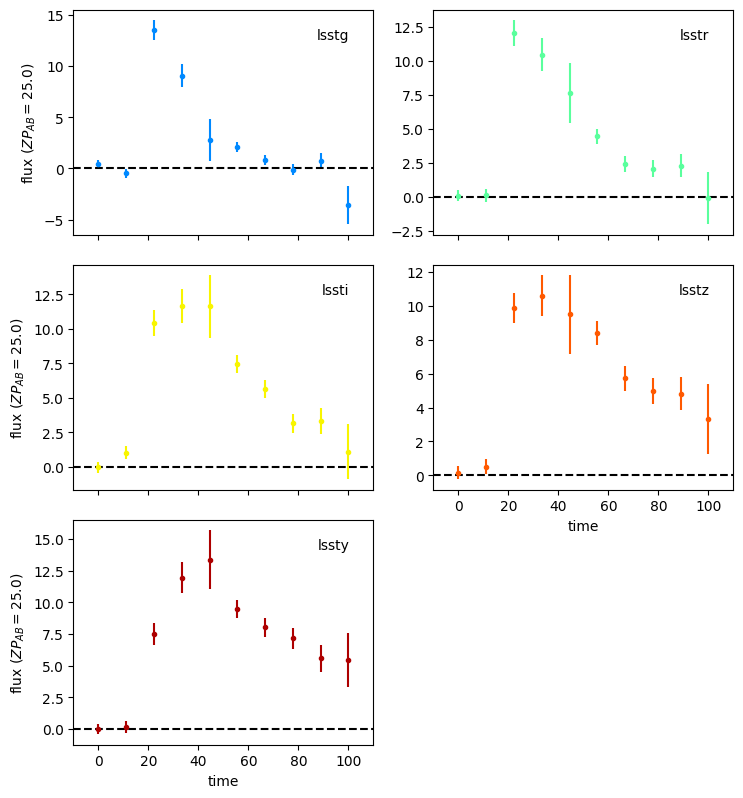

In [360]:
light_curve = simulate_ibc(0.15, 10, 3, 0.1, 10000)
sncosmo.plot_lc(light_curve[0]);

In [361]:
time_points - 5

array([-4.99,  6.12, 17.23, 28.34, 39.45, 50.56, 61.67, 72.78, 83.89,
       95.  ])

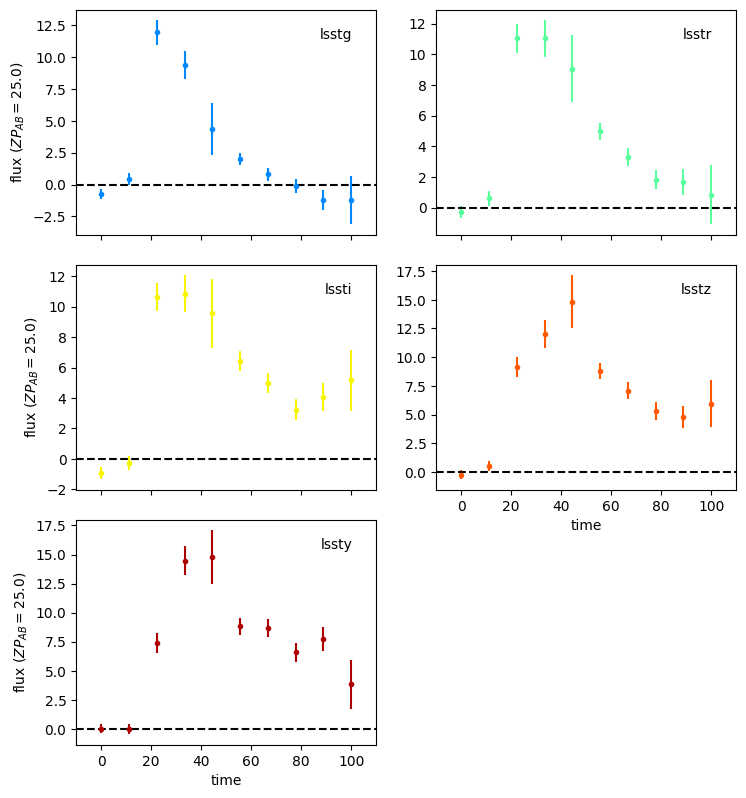

In [362]:
light_curve = simulate_ibc(0.15, 10, 3, 0.1, 10000)
sncosmo.plot_lc(light_curve[0]);

In [363]:
def fit_ibc(true_z, true_texp, lcs):
    arnett_source = ArnettSource(times, wavelengths, true_z, true_texp, params=[1, 0.1, 30000]) # initial parameter values? not sure why these are needed...
    # arnett_source = ArnettSource(times, wavelengths, true_z, params=[ mej, fni, vej])

    arnett_model = sncosmo.Model(source=arnett_source)

    result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['mej', 'vej', 'fni'], 
                                      bounds={'mej':(0.01, 30), 'fni':(0.01, 1), 'vej':(2000, 50000)},
                                     minsnr = 5.0, guess_t0 = False, guess_z = False, guess_amplitude=False)
    # return sncosmo.flatten_result(result)
    return result, fitted_model

In [369]:
result, fitted_model = fit_ibc(0.15, 3, light_curve)

ValueError: `y` must contain only finite values.

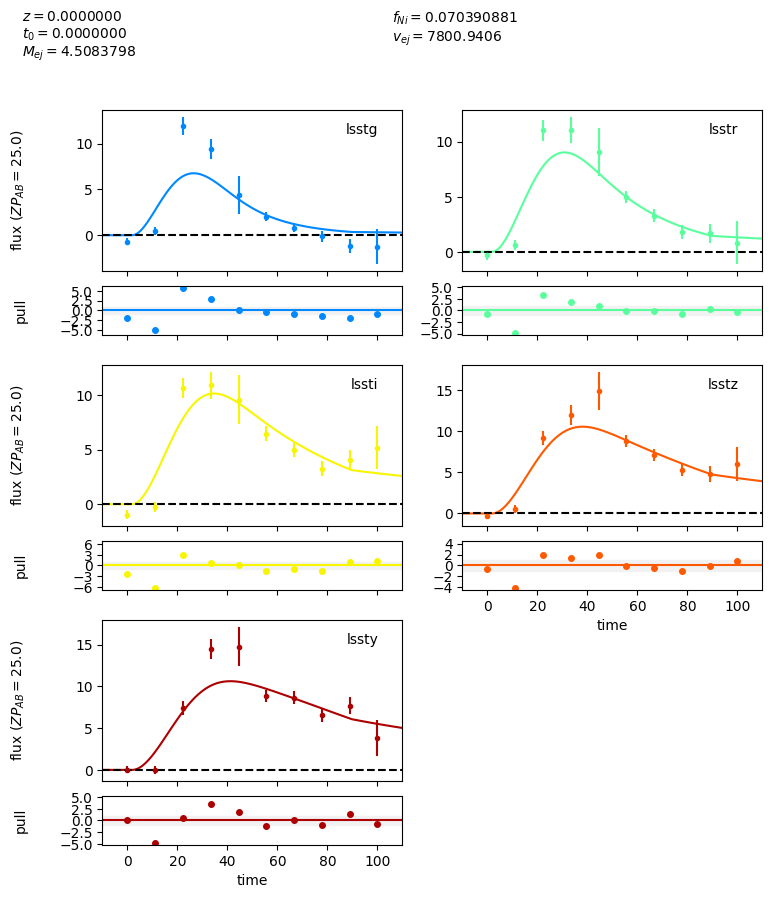

In [368]:
sncosmo.plot_lc(light_curve[0], model=fitted_model);

In [52]:
num_to_fit = 10

fits = {'true_z': [], 'true_texp': [], 'true_mej': [], 'true_fni': [], 'true_vej':[], 'fit_mej':[], 'fit_fni':[], 'fit_vej':[]}

start = time.time()
# for index, row in ibc_df.iterrows():
for true_z, mej, fni, k_energy in zip(ibc_df['true_z'].to_numpy(), ibc_df['Mejecta'].to_numpy(), ibc_df['F_nickel'].to_numpy(), ibc_df['Kinetic_energy'].to_numpy()):
    k_energy *=  1e51 * u.erg
    vej = ((2 * k_energy / (mej * u.Msun))**0.5).to(u.km / u.s)
    
    # this_texp = np.random.uniform(0., 7.)
    this_texp = 1
    print(this_texp)
    
    print(mej, fni, vej)
    # try:
    lcs = simulate_ibc(true_z, this_texp, mej, fni, vej.value)
    # sncosmo.plot_lc(lcs[0])

    result, fitted_model = fit_ibc(true_z, this_texp, lcs)
    result_dict = sncosmo.flatten_result(result)
    fits['true_z'].append(true_z)
    fits['true_texp'].append(this_texp)
    fits['true_mej'].append(mej)
    fits['true_fni'].append(fni)
    fits['true_vej'].append(vej.value)
    fits['fit_mej'].append(result_dict['mej'])
    fits['fit_fni'].append(result_dict['fni'])
    fits['fit_vej'].append(result_dict['vej'])
    # except:
    #     print("Did not work")

    if len(fits['fit_mej']) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)

1
4.046 0.0744 5748.580347068582 km / s


LinAlgError: SVD did not converge

Text(0, 0.5, 'log Fit vej')

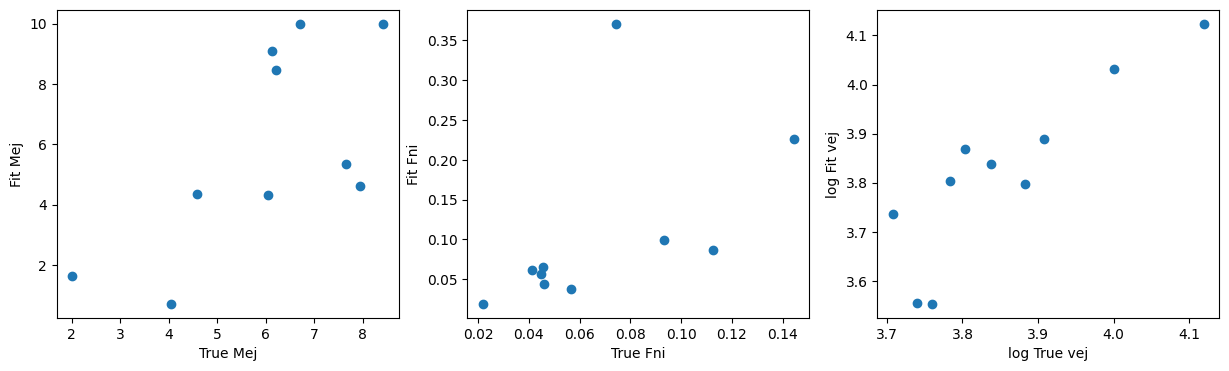

In [10]:
fig, ax = plt.subplots(1,3, figsize=(15, 4))

ax[0].plot(fits['true_mej'], fits['fit_mej'], 'o')
ax[0].set_xlabel("True Mej")
ax[0].set_ylabel("Fit Mej")
ax[1].plot(fits['true_fni'], fits['fit_fni'], 'o')
ax[1].set_xlabel("True Fni")
ax[1].set_ylabel("Fit Fni")
ax[2].plot(np.log10(fits['true_vej']), np.log10(fits['fit_vej']), 'o')
ax[2].set_xlabel("log True vej")
ax[2].set_ylabel("log Fit vej")

(array([2.07478633e-02, 9.22457832e-02, 2.10547751e-01, 3.52009032e-01,
        5.21609113e-01, 6.79261557e-01, 8.63220725e-01, 9.88068057e-01,
        1.16797161e+00, 1.27742637e+00, 1.45128564e+00, 1.52107675e+00,
        1.68399054e+00, 1.71884695e+00, 1.79833084e+00, 1.74175572e+00,
        1.72060073e+00, 1.56861676e+00, 1.46899570e+00, 1.25273250e+00,
        1.03697038e+00, 8.45980425e-01, 6.47646511e-01, 5.08346139e-01,
        3.42707726e-01, 2.23074763e-01, 1.20165361e-01, 6.61269636e-02,
        3.47781166e-02, 2.14681665e-02, 1.23547654e-02, 1.02408322e-02,
        6.81156267e-03, 4.44708919e-03, 3.44492825e-03, 2.52106113e-03,
        1.72246412e-03, 1.19006612e-03, 8.45573297e-04, 7.20303179e-04]),
 array([0.011   , 0.049475, 0.08795 , 0.126425, 0.1649  , 0.203375,
        0.24185 , 0.280325, 0.3188  , 0.357275, 0.39575 , 0.434225,
        0.4727  , 0.511175, 0.54965 , 0.588125, 0.6266  , 0.665075,
        0.70355 , 0.742025, 0.7805  , 0.818975, 0.85745 , 0.895925,
      

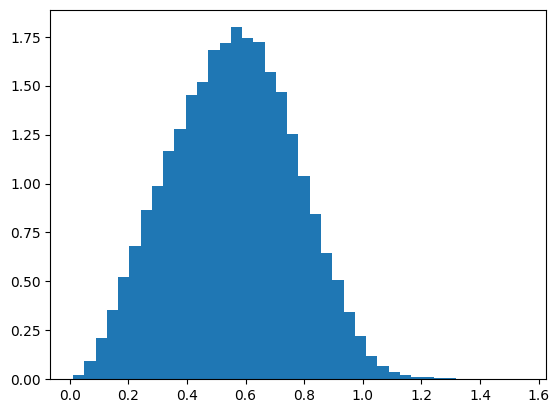

In [11]:
plt.hist(ia_df['true_z'].to_numpy(), bins=40, density=True, label="x1")

In [12]:
def get_x0(mb):
    return 10**(-(mb-10.635)/2.5)

In [13]:
get_x0(np.min(ia_df['salt2_mb'].to_numpy())), get_x0(np.max(ia_df['salt2_mb'].to_numpy()))

(0.047363086913163675, 7.842959998847406e-07)

In [14]:
np.min(ia_df['salt2_color'].to_numpy()), np.max(ia_df['salt2_color'].to_numpy())

(-0.2673, 0.3732)

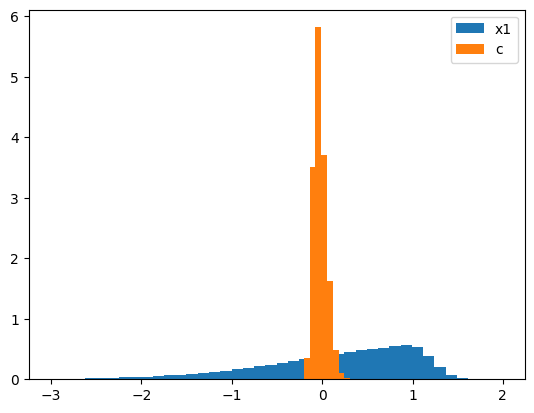

In [15]:
plt.hist(ia_df['salt2_x1'].to_numpy(), bins=40, density=True, label="x1")
plt.hist(ia_df['salt2_color'].to_numpy(), density=True, label="c")
plt.legend()

In [16]:
def simulate_ia(true_z, t0, x0, x1, c):
    params = {'z': true_z, 't0': t0, 'x0':x0, 'x1': x1, 'c':c}
    
    ia_source = sncosmo.get_source('salt2', version='B22')
    
    this_ia_model = sncosmo.Model(source=ia_source)

    lcs = sncosmo.realize_lcs(obs, this_ia_model, [params])

    return lcs

In [17]:
def fit_ia(true_z, lcs):

    # this_ia_model = sncosmo.Model(source='salt2')
    
    ia_source = sncosmo.get_source('salt2', version='B22')
    
    this_ia_model = sncosmo.Model(source=ia_source)
    
    this_ia_model.set(z = true_z)
    
    result, fitted_model = sncosmo.fit_lc(lcs[0], this_ia_model,
    ['t0', 'x0', 'x1', 'c'], minsnr = 1., guess_z = False, bounds={'x0':(0, 0.1), 'x1':(-3, 2), 'c':(-1, 1)})
    
    # return sncosmo.flatten_result(result)
    return result, fitted_model

In [18]:
light_curve = simulate_ia(0.624, 20, get_x0(23.7568), -0.3504, 0.0744)

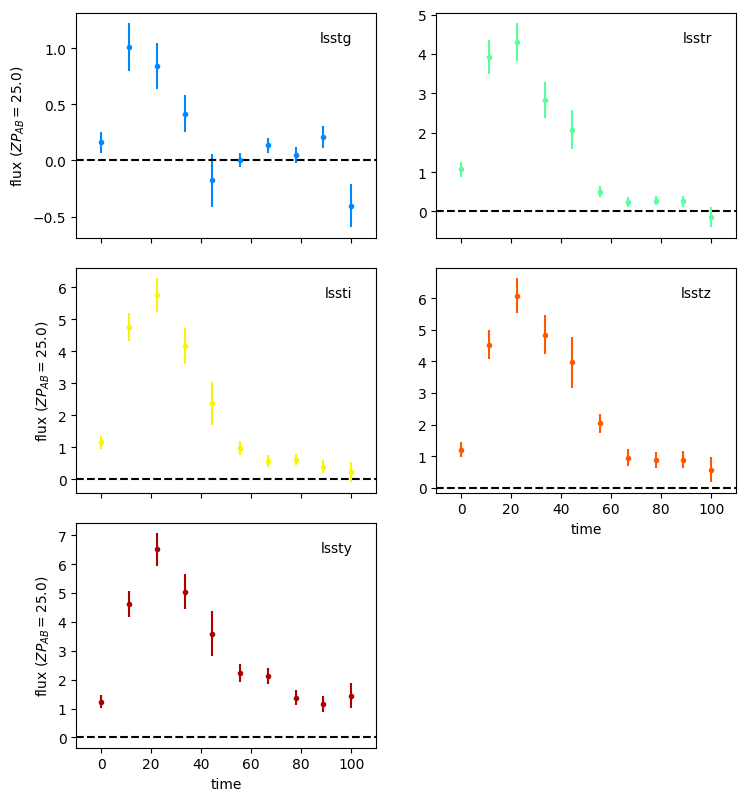

In [19]:
sncosmo.plot_lc(light_curve[0]);

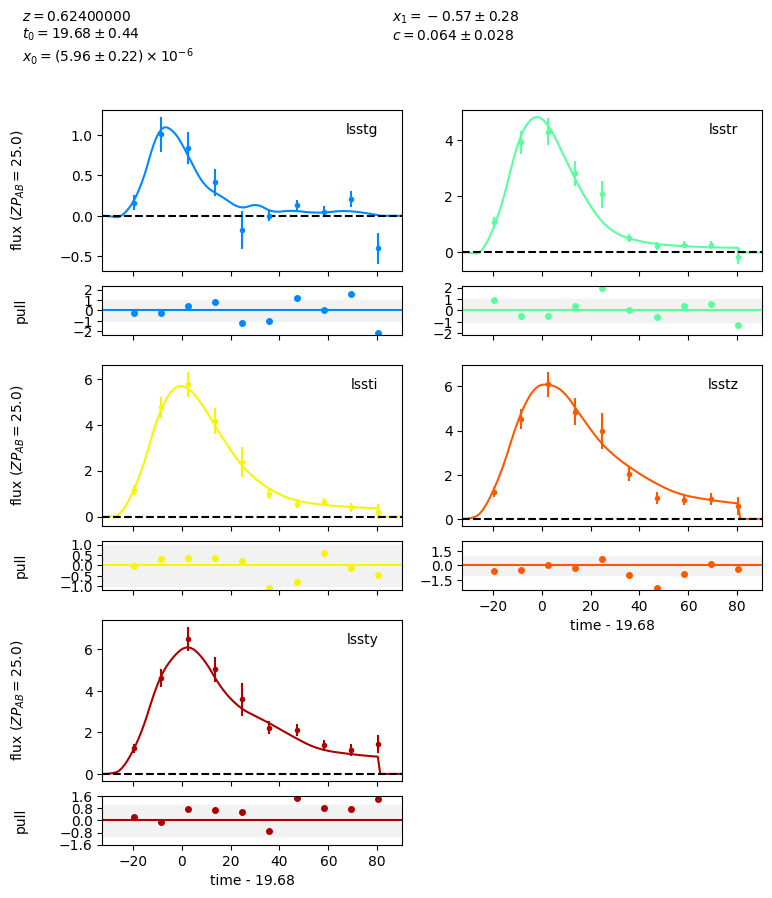

In [20]:
ia_result, ia_fitted_model = fit_ia(0.624,light_curve)
# ibc_result, ibc_fitted_model = fit_ibc(0.274,light_curve)
sncosmo.plot_lc(light_curve[0], model=ia_fitted_model, errors=ia_result.errors);

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


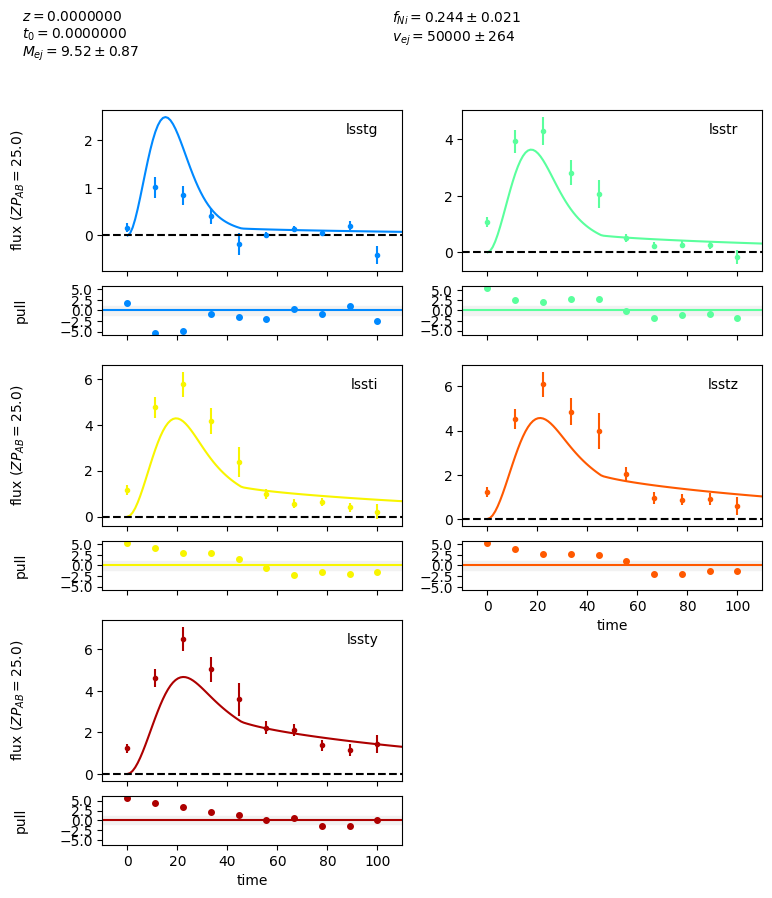

In [21]:
ibc_result, ibc_fitted_model = fit_ibc(0.624,light_curve)
sncosmo.plot_lc(light_curve[0], model=ibc_fitted_model, errors=ibc_result.errors);

In [22]:
num_to_fit = 100

fits = {'true_z': [], 'true_t0': [], 'true_x0': [], 'true_x1':[], 'true_c':[], 'fit_t0':[], 'fit_x0':[], 'fit_x1':[], 'fit_c':[]}

t0 = 20

start = time.time()
# for index, row in ibc_df.iterrows():
for true_z, mb, x1, c in zip(ia_df['true_z'].to_numpy(), ia_df['salt2_mb'].to_numpy(), ia_df['salt2_x1'].to_numpy(), ia_df['salt2_color'].to_numpy()):
    x0 = get_x0(mb)
    
    try:
        lcs = simulate_ia(true_z, t0, x0, x1, c)

        result, model = fit_ia(true_z, lcs)
        
        result_dict = sncosmo.flatten_result(result)
        fits['true_z'].append(true_z)
        fits['true_t0'].append(t0)
        fits['true_x0'].append(x0)
        fits['true_x1'].append(x1)
        fits['true_c'].append(c)
        fits['fit_t0'].append(result_dict['t0'])
        fits['fit_x0'].append(result_dict['x0'])
        fits['fit_x1'].append(result_dict['x1'])
        fits['fit_c'].append(result_dict['c'])
    except:
        print(true_z)
        print("Did not work")

    if len(fits['fit_x0']) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)

0.942
Did not work
1.146
Did not work
0.988
Did not work
1.021
Did not work
1.231
Did not work
1.044
Did not work
1.26
Did not work
1.107
Did not work
1.074
Did not work
1.038
Did not work
1.224
Did not work
0.985
Did not work
0.996
Did not work
1.108
Did not work
1.105
Did not work
1.082
Did not work
1.104
Did not work
1.004
Did not work
1.01
Did not work
1.093
Did not work
1.113
Did not work
1.097
Did not work
1.051
Did not work
1.032
Did not work
1.21
Did not work
1.356
Did not work
0.982
Did not work
1.194
Did not work
1.107
Did not work
0.968
Did not work
1.285
Did not work
1.151
Did not work
1.408
Did not work
1.206
Did not work
1.171
Did not work
1.139
Did not work
1.038
Did not work
1.128
Did not work
1.152
Did not work
1.171
Did not work
1.05
Did not work
1.153
Did not work
0.94
Did not work
0.998
Did not work
1.005
Did not work
1.28
Did not work
1.11
Did not work
1.107
Did not work
1.034
Did not work
1.265
Did not work
1.329
Did not work
1.342
Did not work
0.10055246829986572

Text(0, 0.5, 'log Fit x0')

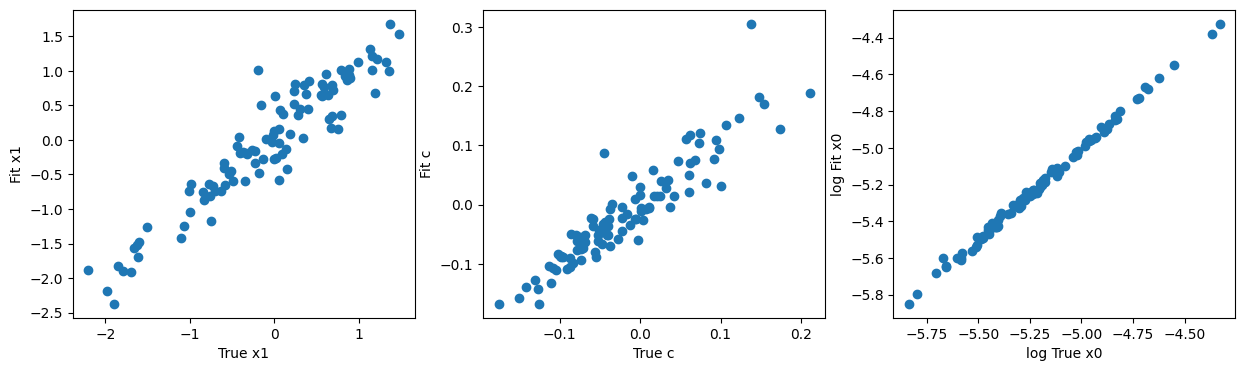

In [23]:
fig, ax = plt.subplots(1,3, figsize=(15, 4))

ax[0].plot(fits['true_x1'], fits['fit_x1'], 'o')
ax[0].set_xlabel("True x1")
ax[0].set_ylabel("Fit x1")
ax[1].plot(fits['true_c'], fits['fit_c'], 'o')
ax[1].set_xlabel("True c")
ax[1].set_ylabel("Fit c")
ax[2].plot(np.log10(fits['true_x0']), np.log10(fits['fit_x0']), 'o')
ax[2].set_xlabel("log True x0")
ax[2].set_ylabel("log Fit x0")

In [24]:
class SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c']
    ibc_keys = ['z', 'mej', 'fni', 'vej']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_dict):
        self.true_class = true_class
        if self.true_class == 'ia':
            self.true_params = {key:true_dict[key] for key in self.ia_keys}
        elif self.true_class == 'ibc':
            self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        else:
            raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}
            


In [25]:
SN('ia', {'z':0.6, 't0':20, 'x0':1e-5, 'x1':0.1, 'c':0.1}).true_class

'ia'

In [34]:
num_to_fit = 100

t0 = 20

true_ia_sne = []

# fit true Ias as both
start = time.time()
for true_z, mb, x1, c in zip(ia_df['true_z'].to_numpy(), ia_df['salt2_mb'].to_numpy(), ia_df['salt2_x1'].to_numpy(), ia_df['salt2_color'].to_numpy()):
    x0 = get_x0(mb)
    
    try:
        print(true_z)
        true_dict = {'z': true_z, 't0':t0, 'x0':x0, 'x1':x1, 'c':c}
        this_sn = SN('ia', true_dict)

        lcs = simulate_ia(true_z, t0, x0, x1, c)

        ia_result, _ = fit_ia(true_z, lcs)

        this_sn.fit_as_ia(sncosmo.flatten_result(ia_result))

        ibc_result, _ = fit_ibc(true_z, lcs)
        # print(sncosmo.flatten_result(ibc_result))
        this_sn.fit_as_ibc(sncosmo.flatten_result(ibc_result))

        true_ia_sne.append(this_sn)
    except:
        print(true_z)
        print("Did not work")

    if len(true_ia_sne) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)


0.624
0.624
Did not work
0.454
0.792
0.942
0.942
Did not work
0.904
0.844
1.146
1.146
Did not work
0.339
0.821
0.456
0.919
0.455
0.455
Did not work
0.438
0.747
0.706
0.899
0.863
0.883
0.988
0.988
Did not work
0.81
0.795
0.795
Did not work
0.641
0.498
0.931
0.509
0.509
Did not work
1.021
1.021
Did not work
0.931
1.231
1.231
Did not work
0.862
0.919
0.506
0.564
1.044
1.044
Did not work
0.502
0.573
0.844
1.26
1.26
Did not work
1.107
1.107
Did not work
0.408
1.074
1.074
Did not work
0.665
0.692
0.675
0.492
0.492
Did not work
1.038
1.038
Did not work
1.224
1.224
Did not work
0.985
0.985
Did not work
0.996
0.996
Did not work
0.754
0.93
0.93
Did not work
0.581
1.108
1.108
Did not work
1.105
1.105
Did not work
0.901
1.082
1.082
Did not work
0.884
1.104
1.104
Did not work
1.004
1.004
Did not work
1.01
1.01
Did not work
1.093
1.093
Did not work
1.113
1.113
Did not work
0.886
1.097
1.097
Did not work
0.803
0.803
Did not work
0.793
0.83
0.83
Did not work
1.051
1.051
Did not work
0.63
0.752
0.809
1

In [51]:
true_ibc_sne = []

# Fit ibc as both
start = time.time()
# for index, row in ibc_df.iterrows():
for true_z, mej, fni, k_energy in zip(ibc_df['true_z'].to_numpy(), ibc_df['Mejecta'].to_numpy(), ibc_df['F_nickel'].to_numpy(), ibc_df['Kinetic_energy'].to_numpy()):
    k_energy *=  1e51 * u.erg
    vej = (((2 * k_energy / (mej * u.Msun))**0.5).to(u.km / u.s)).value
    
    print(mej, fni, vej)
    
    try:
        true_dict = {'z': true_z, 'mej':mej, 'fni':fni, 'vej':vej}
        this_sn = SN('ibc', true_dict)
        
        lcs = simulate_ibc(true_z, mej, fni, vej)

        ia_result, _ = fit_ia(true_z, lcs)

        this_sn.fit_as_ia(sncosmo.flatten_result(ia_result))

        ibc_result, _ = fit_ibc(true_z, lcs)

        this_sn.fit_as_ibc(sncosmo.flatten_result(ibc_result))
        true_ibc_sne.append(this_sn)

    except:
        print("Did not work")

    if len(true_ibc_sne) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)

4.046 0.0744 5748.580347068582
6.1297 0.0565 6364.035693094851
9.8119 0.0849 6533.973178945778
1.1125 0.0801 25485.974243842764
2.0126 0.0448 13163.162093340352
7.9452 0.1443 7627.722958615932
4.5871 0.0931 8095.727773637579
6.7104 0.1127 10015.866271790786
6.2047 0.0218 6066.170004337498
8.4227 0.046 5106.1443009025215
7.6562 0.0414 6873.203627108863
6.0427 0.0457 5486.024578416964
9.7937 0.1434 10052.371694408132
4.7711 0.1039 11776.231098083292
9.0368 0.1216 10509.464307867253
7.676 0.0236 7102.908244061817
1.9116 0.0775 22494.745383865087
8.3425 0.0439 8270.792385427489
Did not work
3.2159 0.0876 10436.08554568497
7.5907 0.1152 11077.652213588413
9.2124 0.1203 4965.42985184157
6.3147 0.0708 6660.847135867068
Did not work
7.3484 0.0632 8862.212021038078
7.8945 0.0432 10657.325313706286
8.5474 0.0849 9884.976095453932
3.5871 0.1145 12014.023533246253
Did not work
7.6387 0.0323 5347.271465013608
3.5224 0.0459 9229.466811967826
0.6741 0.0593 25052.736088312366
Did not work
5.4863 0.045

In [67]:
all_sne = true_ia_sne + true_ibc_sne
fit_x1 = [sn.ia_fit['x1'] for sn in all_sne]
fit_t0 = [sn.ia_fit['t0'] for sn in all_sne]
fit_c = [sn.ia_fit['c'] for sn in all_sne]
fit_x0 = [sn.ia_fit['x0'] for sn in all_sne]
fit_mej = [sn.ibc_fit['mej'] for sn in all_sne]
fit_fni = [sn.ibc_fit['fni'] for sn in all_sne]
fit_vej = [sn.ibc_fit['vej'] for sn in all_sne]

(array([122.,  33.,  31.,   4.,   2.,   0.,   1.,   0.,   4.,   3.]),
 array([ 14.77347295,  27.05185687,  39.33024079,  51.60862471,
         63.88700862,  76.16539254,  88.44377646, 100.72216038,
        113.0005443 , 125.27892822, 137.55731214]),
 <BarContainer object of 10 artists>)

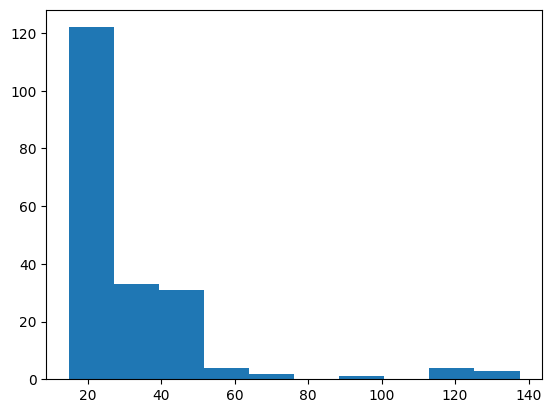

In [68]:
plt.hist(fit_t0)

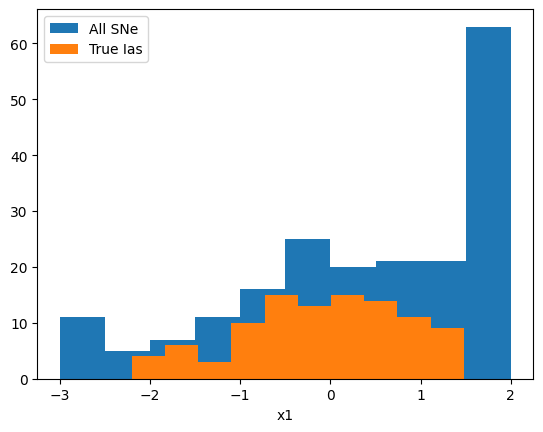

In [53]:
plt.hist(fit_x1, label="All SNe")
plt.hist([sn.true_params['x1'] for sn in true_ia_sne], label="True Ias")
plt.xlabel("x1")
plt.legend()

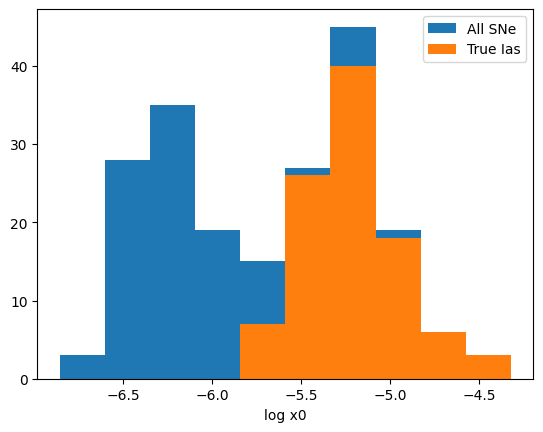

In [60]:
_, bins, _ = plt.hist(np.log10(fit_x0), label="All SNe")
plt.hist(np.log10([sn.true_params['x0'] for sn in true_ia_sne]), label="True Ias", bins=bins)
plt.xlabel("log x0")
plt.legend()

In [76]:
ibc_mask = [sn in true_ibc_sne for sn in all_sne]

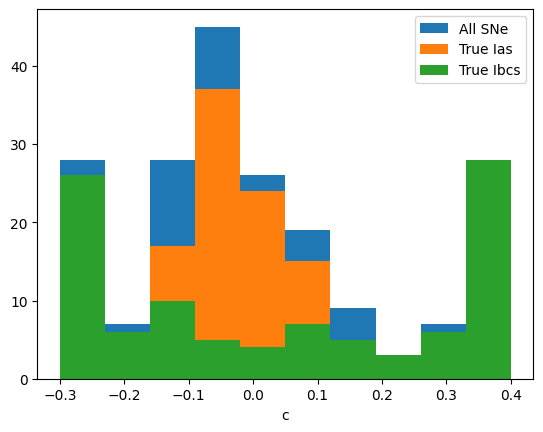

In [79]:
_, bins, _ = plt.hist(fit_c, label="All SNe")
plt.hist([sn.true_params['c'] for sn in true_ia_sne], label="True Ias", bins=bins)
plt.hist(fit_c[(len(fit_c)//2):len(fit_c)], label="True Ibcs", bins=bins)

plt.xlabel("c")
plt.legend()

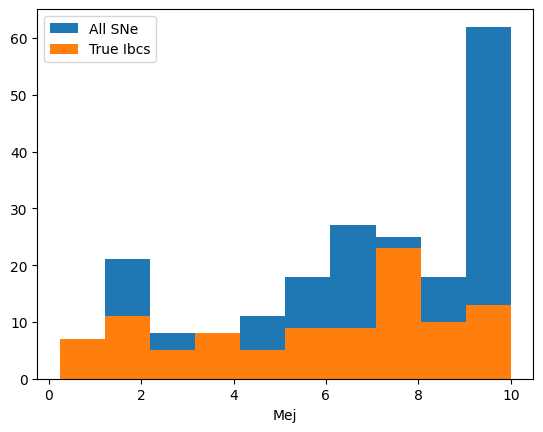

In [59]:
_, bins, _ = plt.hist(fit_mej, label="All SNe")
plt.hist([sn.true_params['mej'] for sn in true_ibc_sne], label="True Ibcs", bins=bins)
plt.xlabel("Mej")
plt.legend()

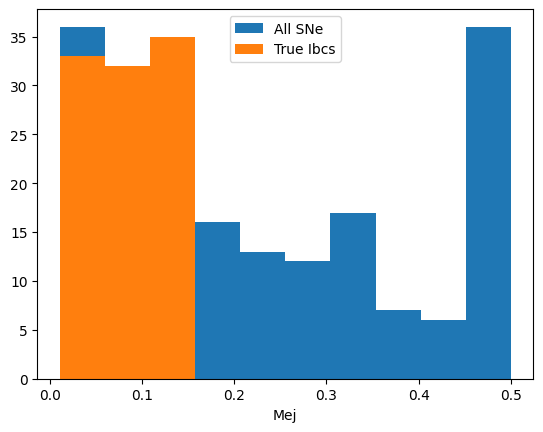

In [58]:
_, bins, _ = plt.hist(fit_fni, label="All SNe")
plt.hist([sn.true_params['fni'] for sn in true_ibc_sne], label="True Ibcs", bins=bins)
plt.xlabel("Mej")
plt.legend()

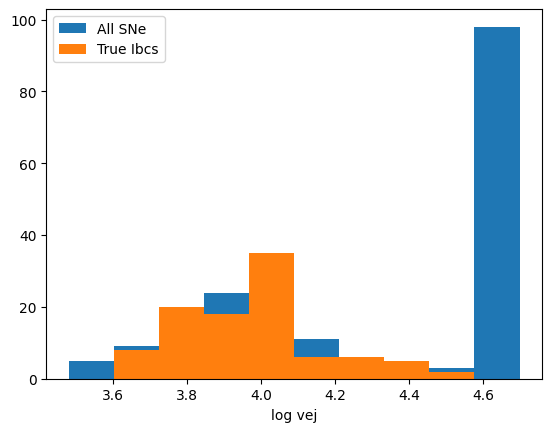

In [66]:
_, bins, _ = plt.hist(np.log10(fit_vej), label="All SNe")
plt.hist(np.log10([sn.true_params['vej'] for sn in true_ibc_sne]), label="True Ibcs", bins=bins)
plt.xlabel("log vej")
plt.legend()

The reason that the higher redshifts aren't working is because the lsst g band is out of the wavelength range